In [38]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import v2
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset
from torch import flatten, optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is", device)

device is cuda:0


In [39]:
BATCH_SIZE = 8

# Define the transformations to apply to the dataset 
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),    # Convert PIL image to tensor
    transforms.Normalize(mean=[0], std=[1])
    ])    # Normalize the image

# Load the CIFAR-10 training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

# Create a DataLoader to load the data in batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

# Create a DataLoader for the test data
testloader = torch.utils.data.DataLoader(testset, BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# Load the CIFAR-10 test dataset
testset_SVHN = torchvision.datasets.SVHN(root='./data',
                                       download=True, transform=transform)

# Create a DataLoader for the test data
testloader_SVHN = torch.utils.data.DataLoader(testset_SVHN, BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# Split the training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])


# Define the classes in CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

val_loader = torch.utils.data.DataLoader(valset, BATCH_SIZE, shuffle=False, num_workers=2)


Using downloaded and verified file: ./data\train_32x32.mat


# Help Functions

In [40]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
class CNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        
        self.act = nn.Tanh()

        # input: 32x32x1
        self.c1 = nn.Conv2d(1, 3, kernel_size=3, padding=1) # output: 32x32x3 SAME
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 16x16x3 

        self.c2 = nn.Conv2d(3, 6, kernel_size=3, padding=1) # output: 16x16x6 SAME
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 8x8x6 
        
        self.c3 = nn.Conv2d(6, 12, kernel_size=3, padding=1) # output: 8x8x12 SAME
        
        self.fc1 = nn.Linear(in_features=8*8*12, out_features=60) 

        self.fc2 = nn.Linear(in_features=60, out_features=num_classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)


    
    def forward(self, x):
        #Conv Layer 1
        x = self.c1(x)
        x = self.act(x)
        x = self.pool1(x)
        
        #Conv Layer 2        
        x = self.c2(x)
        x = self.act(x)
        x = self.pool2(x)

        #Conv Layer 3
        x = self.c3(x)
        x = self.act(x)

        #Flattening
        x = torch.flatten(x, 1)

        #FC Layer 1
        x = self.fc1(x)
        x = self.act(x)

        #FC Layer 2
        x = self.fc2(x)       
        
        #Softmax
        out = self.logSoftmax(x)

        return out
    

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    best_val_loss = float('inf')
    best_model = model

    for epoch in range(num_epochs):
        print(epoch, "ANTON")
        model.train()
        train_loss = 0.0
        for batch_nr, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss = loss.to(device)
            if (batch_nr%300 == 0):
                print("batch_nr:",batch_nr," loss:",loss.item())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        writer.add_scalar("loss/train", train_loss, epoch)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
        
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    
    writer.add_scalar("loss/val", val_loss, epoch)
    
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
    
    writer.flush()
    return best_model

def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []

        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

        test_loss /= len(test_loader.dataset)
        accuracy = 100 * correct / total
        
        # Calculate confusion matrix
        conf_matrix = confusion_matrix(all_targets, all_predictions)

    return test_loss, accuracy, conf_matrix

cuda:0
0 ANTON
batch_nr: 0  loss: 2.2672457695007324
batch_nr: 300  loss: 1.494881272315979
batch_nr: 600  loss: 1.0306320190429688
batch_nr: 900  loss: 0.9751195907592773
batch_nr: 1200  loss: 0.6761773228645325
batch_nr: 1500  loss: 0.9750804305076599
batch_nr: 1800  loss: 0.2526091933250427
batch_nr: 2100  loss: 0.8025456070899963
batch_nr: 2400  loss: 0.30564194917678833
batch_nr: 2700  loss: 0.5600559115409851
batch_nr: 3000  loss: 0.4394932985305786
batch_nr: 3300  loss: 0.36836904287338257
batch_nr: 3600  loss: 0.1660766452550888
batch_nr: 3900  loss: 0.23828867077827454
batch_nr: 4200  loss: 0.04038026183843613
batch_nr: 4500  loss: 0.4284820854663849
batch_nr: 4800  loss: 0.604835033416748
batch_nr: 5100  loss: 0.10284462571144104
batch_nr: 5400  loss: 0.3042667508125305
batch_nr: 5700  loss: 0.6127976179122925
batch_nr: 6000  loss: 0.6357077360153198
batch_nr: 6300  loss: 0.10501430928707123
batch_nr: 6600  loss: 0.0658196359872818
batch_nr: 6900  loss: 0.22590281069278717
ba

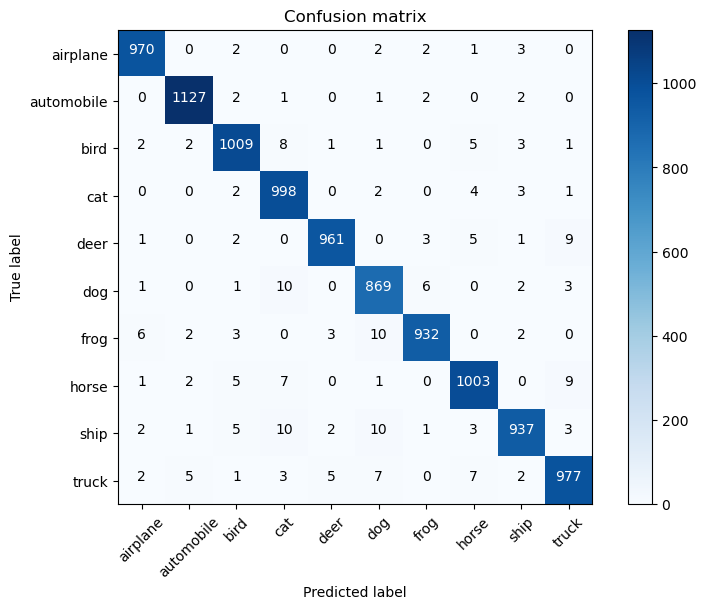

Test SVHN Loss: 0.8342, Test  VHNAccuracy: 11.65%
Confusion matrix, without normalization


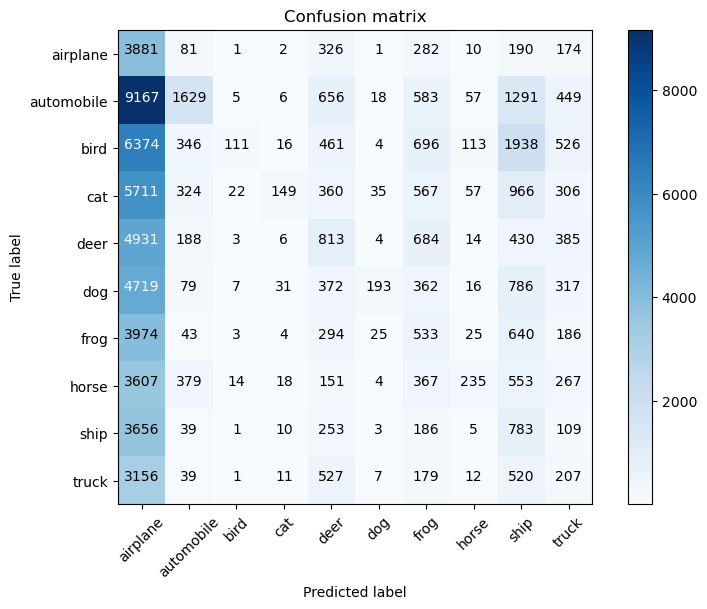

In [42]:
LEARNING_RATE = 0.0001
EPOCHS = 10

print(device)
model = CNN(num_classes=10).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model
trained_model = train_model(model, criterion, optimizer, trainloader, val_loader, EPOCHS)
# Test the MNIST model
test_loss, test_accuracy, conf_matrix = test_model(trained_model, testloader, criterion)
# Test SVHN the model with CNN pre-trainedd on MNIST
test_loss_SVHN, test_accuracy_SVHN, conf_matrix_SVHN = test_model(trained_model, testloader_SVHN, criterion)

# Saves the model
torch.save(trained_model, 'CNN_model.pt')

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, classes=classes, normalize=False)
plt.show()

print(f'Test SVHN Loss: {test_loss_SVHN:.4f}, Test  VHNAccuracy: {test_accuracy_SVHN:.2f}%')
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix_SVHN, classes=classes, normalize=False)
plt.show()

writer.close()